In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/personality_datasert.csv')
df['Drained_after_socializing'] = pd.Series(map(lambda x: x == 'Yes', df['Drained_after_socializing']))
df['Stage_fear'] = pd.Series(map(lambda x: x == 'Yes', df['Stage_fear']))
df['Personality'] = pd.Series(map(lambda x: x == 'Extrovert', df['Personality']))
df

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,False,4.0,6.0,False,13.0,5.0,True
1,9.0,True,0.0,0.0,True,0.0,3.0,False
2,9.0,True,1.0,2.0,True,5.0,2.0,False
3,0.0,False,6.0,7.0,False,14.0,8.0,True
4,3.0,False,9.0,4.0,False,8.0,5.0,True
...,...,...,...,...,...,...,...,...
2895,3.0,False,7.0,6.0,False,6.0,6.0,True
2896,3.0,False,8.0,3.0,False,14.0,9.0,True
2897,4.0,True,1.0,1.0,True,4.0,0.0,False
2898,11.0,True,1.0,3.0,True,2.0,0.0,False


In [10]:
X = df.drop('Personality', axis=1)
y = df['Personality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier1 = SVC(C=2, kernel='linear')
classifier2 = SVC(C=2, kernel='poly')
classifier3 = SVC(C=2, kernel='rbf')
classifier4 = SVC(C=2, kernel='sigmoid')
# classifier5 = SVC(C=2, kernel='precomputed')

scores1 = cross_val_score(classifier1, X_train, y_train, cv=5)
scores2 = cross_val_score(classifier2, X_train, y_train, cv=5)
scores3 = cross_val_score(classifier3, X_train, y_train, cv=5)
scores4 = cross_val_score(classifier4, X_train, y_train, cv=5)
# scores5 = cross_val_score(classifier5, X_train, y_train, cv=5)

print(f"Classifer 1 - linear: {np.average(scores1)}")
print(f"Classifer 2 - poly: {np.average(scores2)}")
print(f"Classifer 3 - rbf: {np.average(scores3)}")
print(f"Classifer 4 - sigmoid: {np.average(scores4)}")
# print(f"Classifer 5 - precomputed: {np.average(scores5)}")

Classifer 1 - linear: 0.9258620689655173
Classifer 2 - poly: 0.9297413793103448
Classifer 3 - rbf: 0.9357758620689655
Classifer 4 - sigmoid: 0.7262931034482758


In [11]:
def avaliate(kernel: str, start=0.1, end=5):
    plot_x = []
    plot_y = []
    for i in np.linspace(start, end, 100):
        classifier = SVC(C=i, kernel=kernel)

        scores = cross_val_score(classifier, X_train, y_train, cv=5)
        score = np.average(scores)

        plot_x.append(i)
        plot_y.append(score)

    return plot_x, plot_y

In [12]:
linear_x, linear_y = avaliate('linear')
poly_x, poly_y = avaliate('poly')
rbf_x, rbf_y = avaliate('rbf')
sigmoid_x, sigmoid_y = avaliate('sigmoid')

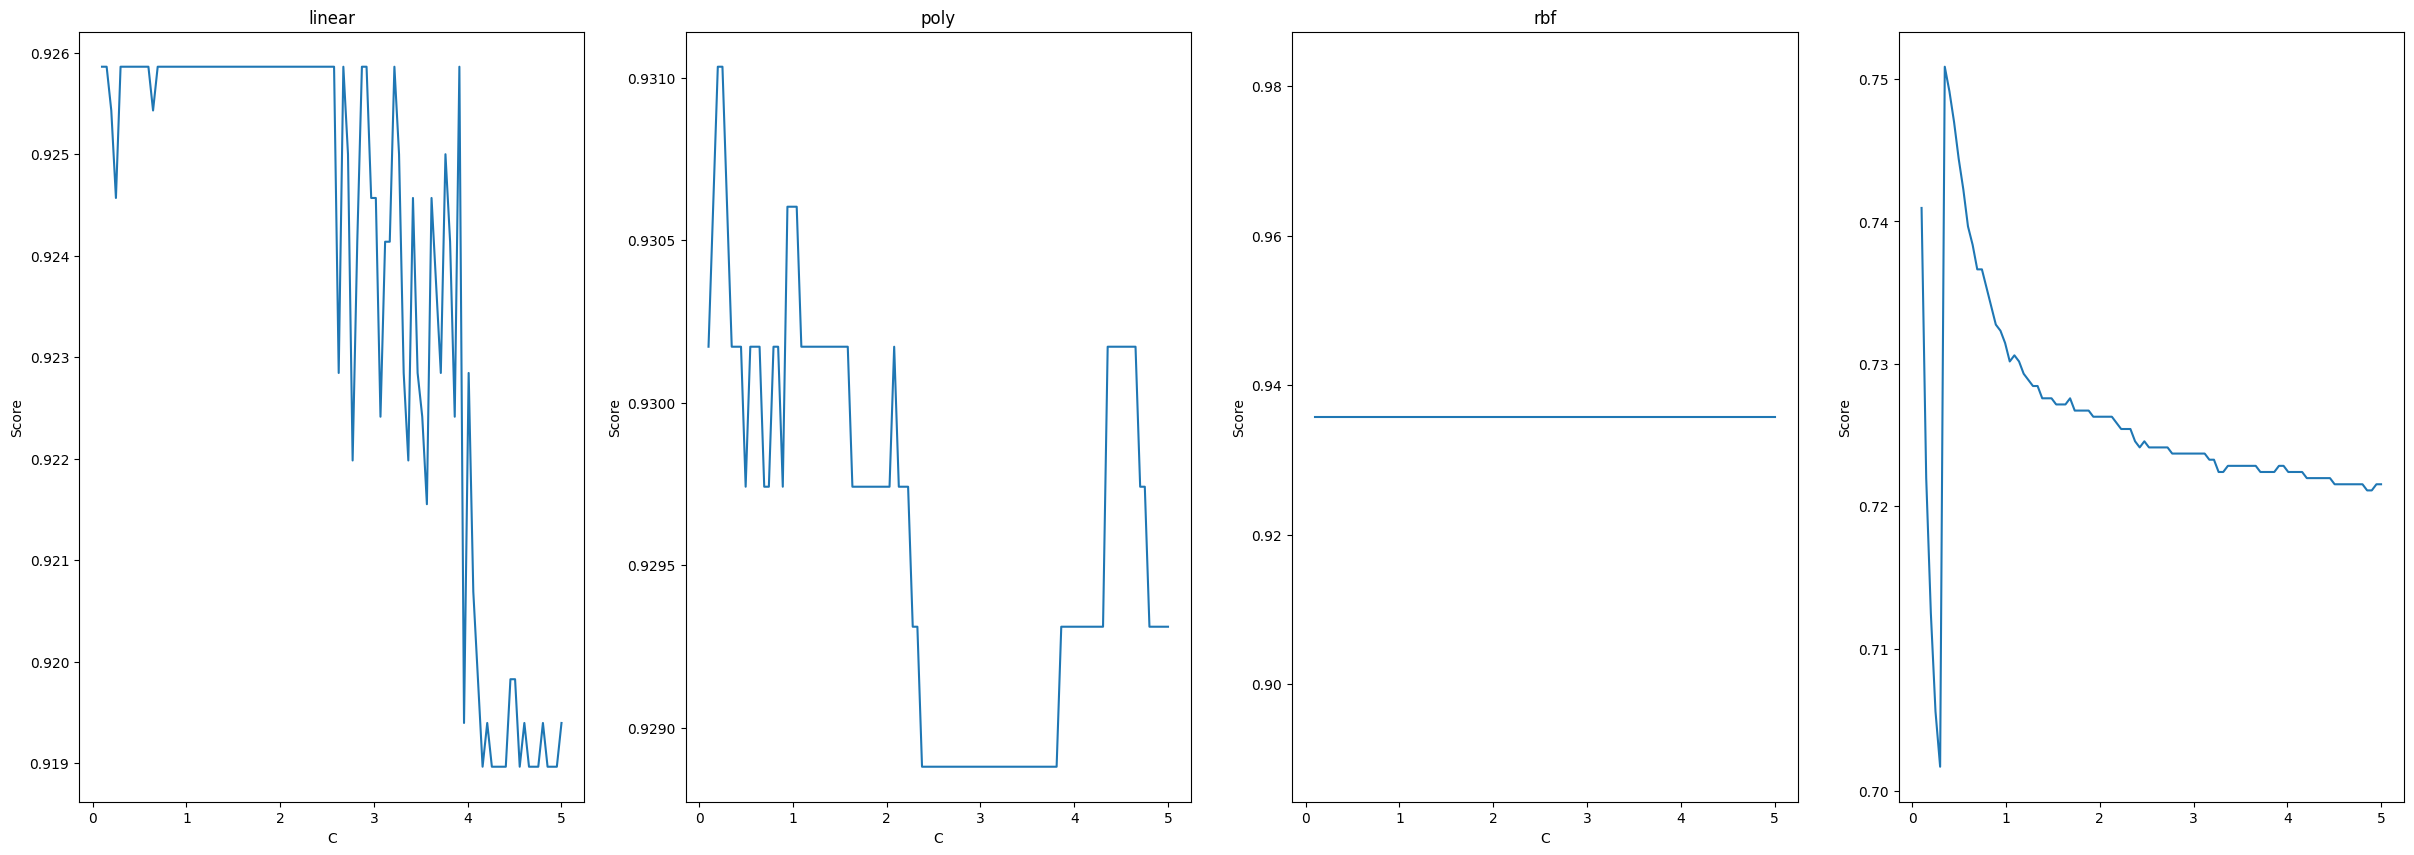

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 10))
ax1.set_title('linear')
ax2.set_title('poly')
ax3.set_title('rbf')

ax1.set_xlabel('C')
ax2.set_xlabel('C')
ax3.set_xlabel('C')


ax1.set_ylabel('Score')
ax2.set_ylabel('Score')
ax3.set_ylabel('Score')
ax4.set_ylabel('Score')

ax1.plot(linear_x, linear_y)
ax2.plot(poly_x, poly_y)
ax3.plot(rbf_x, rbf_y)
ax4.plot(sigmoid_x, sigmoid_y)

## Aqui, os graficos mostraram que o kernel "poly" desempenha melhor
## e seu desempenho parece ser crescente perto do C == 5, então
## será estudado individualmente abaixo

In [14]:
# === 6. Selecionar melhor kernel e C ===
kernel_scores = {
    'linear': max(linear_y),
    'poly': max(poly_y),
    'rbf': max(rbf_y),
    'sigmoid': max(sigmoid_y),
}
best_kernel = max(kernel_scores, key=kernel_scores.get)
best_C = {
    'linear': linear_x[np.argmax(linear_y)],
    'poly': poly_x[np.argmax(poly_y)],
    'rbf': rbf_x[np.argmax(rbf_y)],
    'sigmoid': sigmoid_x[np.argmax(sigmoid_y)],
}[best_kernel]

print(f"Melhor kernel: {best_kernel}, com C = {best_C:.4f}, score CV = {kernel_scores[best_kernel]:.6f}")


Melhor kernel: rbf, com C = 0.1000, score CV = 0.935776


In [15]:
# === 7. Avaliação com cross-val (métricas detalhadas) ===
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=best_C, kernel=best_kernel))
])
y_pred_cv = cross_val_predict(final_model, X_train, y_train, cv=5)

print("\n=== MÉTRICAS NA VALIDAÇÃO CRUZADA (conjunto de treino) ===")
print(f"Acurácia:  {accuracy_score(y_train, y_pred_cv):.6f}")
print(f"Precisão:  {precision_score(y_train, y_pred_cv):.6f}")
print(f"Recall:    {recall_score(y_train, y_pred_cv):.6f}")
print(f"F1-Score:  {f1_score(y_train, y_pred_cv):.6f}")



=== MÉTRICAS NA VALIDAÇÃO CRUZADA (conjunto de treino) ===
Acurácia:  0.935776
Precisão:  0.946735
Recall:    0.926829
F1-Score:  0.936677



=== MÉTRICAS FINAIS NO TESTE ===
              precision    recall  f1-score   support

   Introvert   0.915789  0.938849  0.927176       278
   Extrovert   0.942373  0.920530  0.931323       302

    accuracy                       0.929310       580
   macro avg   0.929081  0.929689  0.929250       580
weighted avg   0.929631  0.929310  0.929335       580



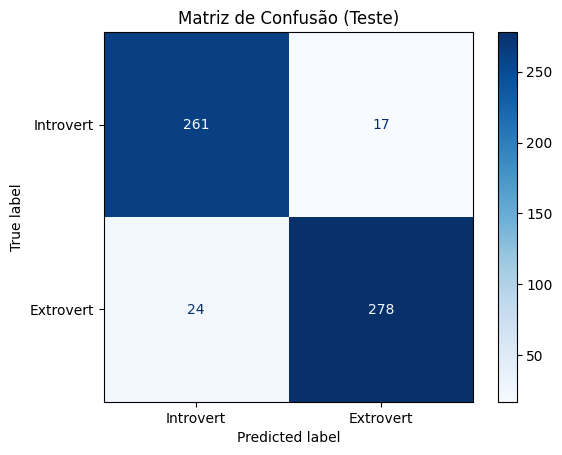

In [16]:
# === 8. Avaliação no conjunto de teste ===
final_model.fit(X_train, y_train)
y_pred_test = final_model.predict(X_test)

print("\n=== MÉTRICAS FINAIS NO TESTE ===")
print(classification_report(y_test, y_pred_test, target_names=['Introvert', 'Extrovert'], digits=6))

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Introvert', 'Extrovert'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão (Teste)")
plt.show()